In [266]:
import pandas as pd
import regex as re 
import spacy
en_core_web_lg = spacy.load('en_core_web_lg')
import en_core_web_lg
import gensim
import multiprocessing
import numpy as np
import twokenize
import nltk
import string
import emoji
import matplotlib.pyplot as plt
import numpy as np


from textblob import TextBlob
from textblob.en import Spelling 
from tqdm.notebook import tqdm
from cleantext import clean
from bs4 import BeautifulSoup
from nltk.tokenize import TweetTokenizer
from nltk.stem.porter import PorterStemmer
tqdm.pandas()
from re import sub
from time import time 
from wordcloud import WordCloud
from gensim.models import Word2Vec
from collections import defaultdict
from gensim.models import KeyedVectors
from gensim.test.utils import get_tmpfile
from gensim.models.phrases import Phrases, Phraser
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [267]:
tweets_df = pd.read_csv('tweets.csv', index_col = 0)

In [268]:
tweets_df['text'].iloc[124,]

'🚨BREAKING: SB23-188 is UNCONSTITUTIONAL according to State Legal Services, per the good faith inquiries of the @CoHouseGOP minority.\n\n@CoHouseDEM should NOT have introduced this unconstitutional bill that combined Abortion &amp; Gender Affirming Care! #SB188 #CoLeg #CoPolitics https://t.co/3Eq3mUGN5G'

# Preprocessing, cleaning data

In [269]:
tweets_df_cleaned = tweets_df.drop_duplicates(subset=['text']).reset_index(drop=True)
tweets_df_cleaned = tweets_df_cleaned.dropna()

date            author_id   
0      2023-03-31 00:54:56+00:00             80832189  \
1      2023-03-31 00:54:50+00:00           2479303121   
2      2023-03-31 00:52:32+00:00  1526105788728475653   
3      2023-03-31 00:52:09+00:00            438628988   
4      2023-03-31 00:51:47+00:00  1492201362154831874   
...                          ...                  ...   
24832  2023-02-23 02:42:35+00:00  1492272489455620097   
24833  2023-02-23 02:29:15+00:00            452462161   
24834  2023-02-23 02:27:01+00:00  1519800752549421058   
24835  2023-02-23 02:25:21+00:00  1445411972388847622   
24836  2023-02-23 02:20:52+00:00             78746288   

                                                    text  
0      Ron DeSantis just stated he would not honor a ...  
1      Abortion is completely legal and in our consti...  
2      @felicia_hart13 @Thisisa74798027 @kyle_macdowe...  
3      @sbaprolife @MichaelBennet @CNN @SenTuberville...  
4      @picelandy @JoeBiden Democrats that want to le...  
...                                                  ...  
24832  @ClownWorld_ abortion up to 9 months shouldn’t...  
24833  @RochNH2014 @mikereinholz777 @GeorgeTakei SCOT...  
24834  @JohnBoyThinks @StudentsforLife Yes. And I wil...  
24835  @beccaboo8u @Darlene_McD Also, due to the inju...  
24836  Blue America wants to make abortion legal up u...  

[24837 rows x 3 columns]

In [270]:
tweets_df_cleaned['text'] = tweets_df_cleaned['text'].astype(str)

In [271]:
amp = re.compile(r'&amp;')
tweets_df_cleaned['text']  = tweets_df_cleaned['text'].apply(lambda x: amp.sub('', x))

In [272]:
nicknames = re.compile(r'@\w+')
tweets_df_cleaned['text'] = tweets_df_cleaned['text'].apply(lambda x: nicknames.sub('', x))

In [273]:
url_re = re.compile(r'((www.[^\s]+)|(https?:[^\s])|(/t\.co/\S+))')
tweets_df_cleaned['text'] = tweets_df_cleaned['text'].apply(lambda x: url_re.sub('', x))

In [274]:
tweets_df_cleaned['original_tweets'] = tweets_df_cleaned['text']

In [275]:
tweets_df_cleaned['text'] = tweets_df_cleaned['text'].apply(lambda x: x.lower())

In [276]:
tweets_df_cleaned['text'] = tweets_df_cleaned['text'].apply(lambda x: emoji.demojize(str(x)))

In [277]:
tweets_df_cleaned['text'] = tweets_df_cleaned['text'].str.replace(r'\b(yeah|etc)\b', '', regex=True)

In [278]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [279]:
tweets_df_cleaned['text'] = tweets_df_cleaned['text'].apply(strip_html)

/var/folders/f8/45gtfsk111s8zwsfwv07l26c0000gq/T/ipykernel_43913/1888600689.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [280]:
tweets_df_cleaned = tweets_df_cleaned.drop_duplicates(subset=['text']).reset_index(drop=True)
tweets_df_cleaned = tweets_df_cleaned.dropna()

date            author_id   
0      2023-03-31 00:54:56+00:00             80832189  \
1      2023-03-31 00:54:50+00:00           2479303121   
2      2023-03-31 00:52:32+00:00  1526105788728475653   
3      2023-03-31 00:52:09+00:00            438628988   
4      2023-03-31 00:51:47+00:00  1492201362154831874   
...                          ...                  ...   
22482  2023-02-23 02:42:35+00:00  1492272489455620097   
22483  2023-02-23 02:29:15+00:00            452462161   
22484  2023-02-23 02:27:01+00:00  1519800752549421058   
22485  2023-02-23 02:25:21+00:00  1445411972388847622   
22486  2023-02-23 02:20:52+00:00             78746288   

                                                    text   
0      ron desantis just stated he would not honor a ...  \
1      abortion is completely legal and in our consti...   
2         "forced pregnancy" is a legal term specific...   
3          americans know this is true, which is why ...   
4        democrats that want to legalize abortion don...   
...                                                  ...   
22482   abortion up to 9 months shouldn’t be legal, a...   
22483     scotus also rules decades ago that privacy,...   
22484    yes. and i will go to all means to obtain an...   
22485    also, due to the injunction (incorrectly) pl...   
22486  blue america wants to make abortion legal up u...   

                                         original_tweets  
0      Ron DeSantis just stated he would not honor a ...  
1      Abortion is completely legal and in our consti...  
2         "Forced pregnancy" is a legal term specific...  
3          Americans know this IS true, which is why ...  
4        Democrats that want to legalize abortion don...  
...                                                  ...  
22482   abortion up to 9 months shouldn’t be legal, a...  
22483     SCOTUS also rules decades ago that privacy,...  
22484    Yes. And I will go to all means to obtain an...  
22485    Also, due to the injunction (incorrectly) pl...  
22486  Blue America wants to make abortion legal up u...  

[22487 rows x 4 columns]

In [281]:
def fix_spaced_words(text):
    return re.sub(r"\b(\w)\s+(?=\w\s)+", r"\1", text)
tweets_df_cleaned['text'] = tweets_df_cleaned['text'].apply(fix_spaced_words)

In [282]:
tweets_df_cleaned['text'].iloc[147,]

' i hear some humans use abortion as birth control. yet this is brutal? amazing how important it is to be able to kill a baby. abortion kills more kids that any guns. but that’s legal!'

In [283]:
en_core_web_lg = spacy.load('en_core_web_lg')

In [284]:
nlp = spacy.load('en_core_web_lg', disable=['ner', 'parser'])
nlp.add_pipe('sentencizer')

In [285]:
nlp.Defaults.stop_words

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'fron

In [286]:
def remove_stopwords(text):
    doc = nlp(text)
    return ' '.join([token.text for token in doc if not token.is_stop])

In [287]:
tweets_df_cleaned['text'] = tweets_df_cleaned['text'].apply(remove_stopwords)

In [288]:
tweets_df_cleaned['text'].iloc[273,]

'    morals = murder - sick world ? happens pushes abortion demand murdering baby 1 week birth . pro - choice like rare , safe , legal thrown door . sick !'

In [289]:
tweets_df_cleaned

date            author_id   
0      2023-03-31 00:54:56+00:00             80832189  \
1      2023-03-31 00:54:50+00:00           2479303121   
2      2023-03-31 00:52:32+00:00  1526105788728475653   
3      2023-03-31 00:52:09+00:00            438628988   
4      2023-03-31 00:51:47+00:00  1492201362154831874   
...                          ...                  ...   
22482  2023-02-23 02:42:35+00:00  1492272489455620097   
22483  2023-02-23 02:29:15+00:00            452462161   
22484  2023-02-23 02:27:01+00:00  1519800752549421058   
22485  2023-02-23 02:25:21+00:00  1445411972388847622   
22486  2023-02-23 02:20:52+00:00             78746288   

                                                    text   
0      ron desantis stated honor legal requirement ex...  \
1             abortion completely legal constitution . .   
2          " forced pregnancy " legal term specifical...   
3           americans know true , 80 % believe aborti...   
4            democrats want legalize abortion scruples .   
...                                                  ...   
22482    abortion 9 months legal , past trimester ill...   
22483      scotus rules decades ago privacy , fundame...   
22484                yes . means obtain abortion legal .   
22485     , injunction ( incorrectly ) placed trigger...   
22486  blue america wants abortion legal mother takes...   

                                         original_tweets  
0      Ron DeSantis just stated he would not honor a ...  
1      Abortion is completely legal and in our consti...  
2         "Forced pregnancy" is a legal term specific...  
3          Americans know this IS true, which is why ...  
4        Democrats that want to legalize abortion don...  
...                                                  ...  
22482   abortion up to 9 months shouldn’t be legal, a...  
22483     SCOTUS also rules decades ago that privacy,...  
22484    Yes. And I will go to all means to obtain an...  
22485    Also, due to the injunction (incorrectly) pl...  
22486  Blue America wants to make abortion legal up u...  

[22487 rows x 4 columns]

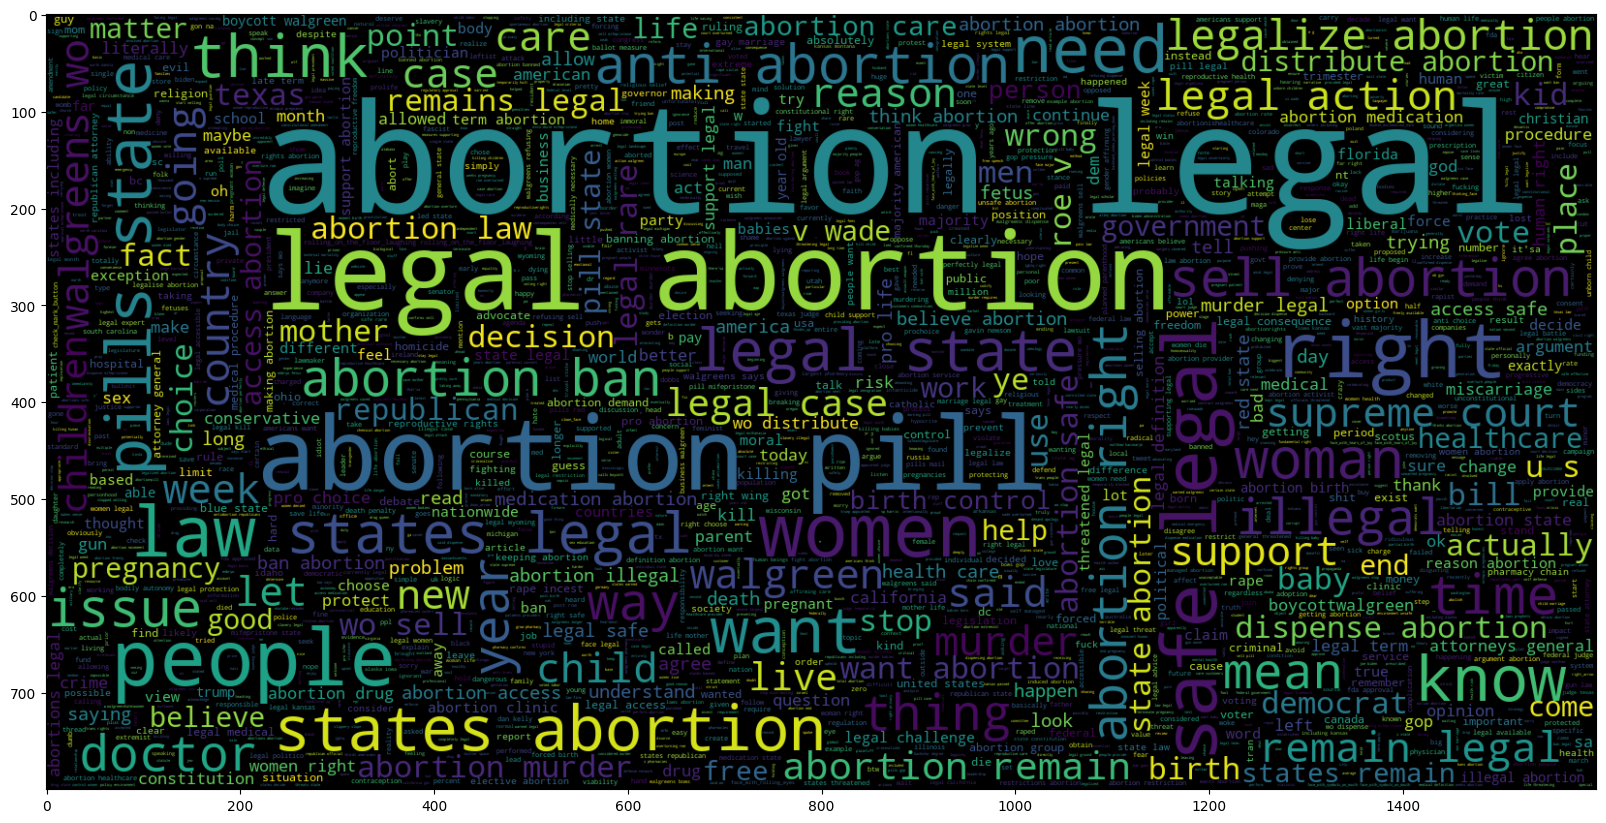

In [291]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(tweets_df_cleaned.text))
plt.imshow(wc , interpolation = 'bilinear')

In [292]:
tknzr = TweetTokenizer()

def tokenize_text(text):
    tokens = tknzr.tokenize(text)
    return tokens

tweets_df_cleaned['tokens'] = tweets_df_cleaned['text'].apply(tokenize_text)

In [293]:
tweets_df_cleaned['tokens'] = tweets_df_cleaned['tokens'].apply(lambda lst: [word.lower() for word in lst])

In [294]:
def filter_tokens(tokens):
    pattern = re.compile(r'[^a-zA-Z0-9]')
    filtered_tokens = []
    for token in tokens:
        filtered_token = re.sub(pattern, '', token.translate(str.maketrans('', '', string.punctuation)))
        if len(filtered_token) > 1:
            filtered_tokens.append(filtered_token)
    return filtered_tokens

In [295]:
tweets_df_cleaned['cleaned_tokens'] = tweets_df_cleaned['tokens'].apply(filter_tokens)

In [296]:
tweets_df_cleaned

date            author_id   
0      2023-03-31 00:54:56+00:00             80832189  \
1      2023-03-31 00:54:50+00:00           2479303121   
2      2023-03-31 00:52:32+00:00  1526105788728475653   
3      2023-03-31 00:52:09+00:00            438628988   
4      2023-03-31 00:51:47+00:00  1492201362154831874   
...                          ...                  ...   
22482  2023-02-23 02:42:35+00:00  1492272489455620097   
22483  2023-02-23 02:29:15+00:00            452462161   
22484  2023-02-23 02:27:01+00:00  1519800752549421058   
22485  2023-02-23 02:25:21+00:00  1445411972388847622   
22486  2023-02-23 02:20:52+00:00             78746288   

                                                    text   
0      ron desantis stated honor legal requirement ex...  \
1             abortion completely legal constitution . .   
2          " forced pregnancy " legal term specifical...   
3           americans know true , 80 % believe aborti...   
4            democrats want legalize abortion scruples .   
...                                                  ...   
22482    abortion 9 months legal , past trimester ill...   
22483      scotus rules decades ago privacy , fundame...   
22484                yes . means obtain abortion legal .   
22485     , injunction ( incorrectly ) placed trigger...   
22486  blue america wants abortion legal mother takes...   

                                         original_tweets   
0      Ron DeSantis just stated he would not honor a ...  \
1      Abortion is completely legal and in our consti...   
2         "Forced pregnancy" is a legal term specific...   
3          Americans know this IS true, which is why ...   
4        Democrats that want to legalize abortion don...   
...                                                  ...   
22482   abortion up to 9 months shouldn’t be legal, a...   
22483     SCOTUS also rules decades ago that privacy,...   
22484    Yes. And I will go to all means to obtain an...   
22485    Also, due to the injunction (incorrectly) pl...   
22486  Blue America wants to make abortion legal up u...   

                                                  tokens   
0      [ron, desantis, stated, honor, legal, requirem...  \
1       [abortion, completely, legal, constitution, . .]   
2      [", forced, pregnancy, ", legal, term, specifi...   
3      [americans, know, true, ,, 80, %, believe, abo...   
4      [democrats, want, legalize, abortion, scruples...   
...                                                  ...   
22482  [abortion, 9, months, legal, ,, past, trimeste...   
22483  [scotus, rules, decades, ago, privacy, ,, fund...   
22484        [yes, ., means, obtain, abortion, legal, .]   
22485  [,, injunction, (, incorrectly, ), placed, tri...   
22486  [blue, america, wants, abortion, legal, mother...   

                                          cleaned_tokens  
0      [ron, desantis, stated, honor, legal, requirem...  
1            [abortion, completely, legal, constitution]  
2      [forced, pregnancy, legal, term, specifically,...  
3      [americans, know, true, 80, believe, abortion,...  
4        [democrats, want, legalize, abortion, scruples]  
...                                                  ...  
22482  [abortion, months, legal, past, trimester, ill...  
22483  [scotus, rules, decades, ago, privacy, fundame...  
22484              [yes, means, obtain, abortion, legal]  
22485  [injunction, incorrectly, placed, trigger, ban...  
22486  [blue, america, wants, abortion, legal, mother...  

[22487 rows x 6 columns]

In [297]:
nltk.download('punkt')


stemmer = PorterStemmer()

def stem_words(tokens):
    return [stemmer.stem(token) for token in tokens]

tweets_df_cleaned['stems'] = tweets_df_cleaned['cleaned_tokens'].progress_apply(stem_words)

[nltk_data] Downloading package punkt to /Users/lst/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


  0%|          | 0/22487 [00:00<?, ?it/s]

In [298]:
def lemmatize_words(tokens):
    return [x.lemma_ for x in nlp(' '.join(tokens))]

tweets_df_cleaned['lemma'] = tweets_df_cleaned['cleaned_tokens'].progress_apply(lemmatize_words)

  0%|          | 0/22487 [00:00<?, ?it/s]

In [299]:
def remove_stopwords_list(words_list):
    return [word for word in words_list if word not in nlp.Defaults.stop_words]

In [300]:
tweets_df_cleaned['lemma'] = tweets_df_cleaned['lemma'].apply(lambda x: remove_stopwords_list(x))

In [301]:
tweets_df_cleaned['lemma'] = tweets_df_cleaned['lemma'].apply(lambda x: [token for token in x if len(token) > 2])

In [308]:
tweets_df_cleaned.to_csv('tweets_df_preprocessed.csv')
tweets_df_cleaned.to_excel('tweets_df_preprocessed.xlsx', index=False)

In [303]:
sent = [row for row in tweets_df_cleaned.lemma]
phrases = Phrases(sent, min_count=5, progress_per=50000)
bigram = Phraser(phrases)
sentences = bigram[sent]
sentences[17]

['conservative',
 'vote',
 'legal',
 'apartheid',
 'america',
 'anti',
 'abortion',
 'movement',
 'huge',
 'huge',
 'hustle',
 'permanent',
 'apartheid',
 'america',
 'rubbish',
 'grandstand',
 'ban',
 'teach',
 'true',
 'history',
 'ban_book']

In [304]:
sentences[10]

['woman',
 'florida',
 'suffer',
 'npr',
 'reporter',
 'yesterday',
 'woman',
 'southeast',
 'come',
 'florida',
 'care',
 'year',
 'legal',
 'abortion',
 'southeast']

In [305]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

17883

In [306]:
sorted(word_freq, key=word_freq.get, reverse=True)[:20]

['abortion',
 'legal',
 'state',
 'woman',
 'right',
 'pill',
 'law',
 'people',
 'want',
 'ban',
 'safe',
 'murder',
 'like',
 'walgreen',
 'think',
 'need',
 'support',
 'illegal',
 'know',
 'care']

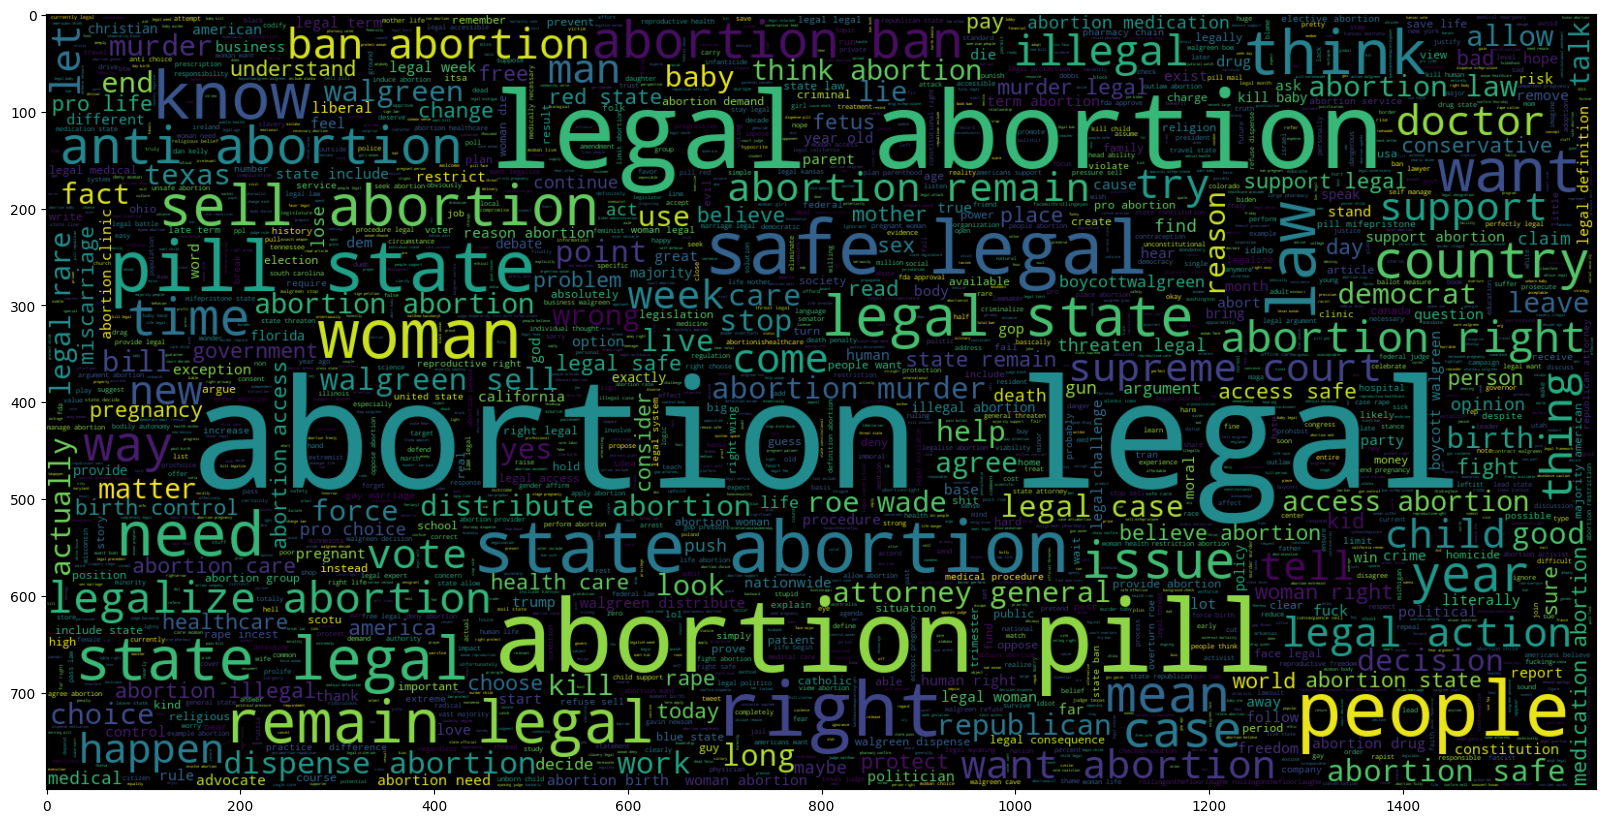

In [310]:
plt.figure(figsize=(20, 20)) 
wc = WordCloud(max_words=2000, width=1600, height=800).generate(' '.join([' '.join(words) for words in tweets_df_cleaned.lemma]))
plt.imshow(wc, interpolation='bilinear')


# Word embeddings

In [311]:
w2v_model = Word2Vec(min_count=5,
                    window=8,
                    vector_size=300,
                    sample=1e-5,
                    alpha=0.03,
                    min_alpha=0.0007,
                    negative=20,
                    workers=multiprocessing.cpu_count()-1)

start = time()

w2v_model.build_vocab(sentences, progress_per=50000)

print('time to build vocab: {} mins',format(round((time()- start) / 60, 2)))

time to build vocab: {} mins 0.01


In [312]:
start = time()

w2v_model.train(sentences,
               total_examples=w2v_model.corpus_count,
               epochs=30,
               report_delay=1)

print('time to train the model: {} mins'. format(round((time() - start) / 60, 2)))

w2v_model.init_sims(replace = True)

time to train the model: 0.15 mins


/var/folders/f8/45gtfsk111s8zwsfwv07l26c0000gq/T/ipykernel_43913/4032002737.py:10: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace = True)


In [313]:
w2v_model.save("word2vec.model")

In [314]:
tweets_df_export = tweets_df_cleaned.copy()
#tweets_df_export['old_text'] = tweets_df_export.text
#tweets_df_export.t = tweets_df_export.old_text.str.join(' ')
tweets_df_export['lemmas_with_bigrams'] = tweets_df_export.lemma.apply(lambda x: ' '.join(bigram[x]))

In [315]:
tweets_df_export['lemmas_with_bigrams'].to_csv('cleaned_dataset.csv', index=False)

In [316]:
# the model words vocabulary
word_vectors = w2v_model.wv
#finding the most similar words to a given word
word_vectors.similar_by_word('killing')

[('definition_murder', 0.999439001083374),
 ('premeditate', 0.9994332194328308),
 ('btw', 0.9994314908981323),
 ('term_apply', 0.9994268417358398),
 ('unlawful_kill', 0.9994193911552429),
 ('meet_criterion', 0.9994174838066101),
 ('semantic', 0.9994170665740967),
 ('kill_baby', 0.9994006752967834),
 ('nuance', 0.9993906021118164),
 ('medical_definition', 0.999387264251709)]

In [317]:
print(word_vectors.similarity('fetus', 'killing'))
print(word_vectors.similarity('women', 'mother'))
w2v_model.wv.most_similar(positive=["fetus"])

0.9963824
0.9966035


[('term', 0.998337984085083),
 ('human', 0.9981377124786377),
 ('baby', 0.9981099963188171),
 ('mother', 0.9980638027191162),
 ('definition', 0.9976744055747986),
 ('legally', 0.9974719285964966),
 ('moral', 0.9974687695503235),
 ('homicide', 0.9974563121795654),
 ('define', 0.9974139332771301),
 ('pregnancy', 0.9973001480102539)]

In [318]:


def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.index_to_key[:150]:
        tokens.append(model.wv.get_vector(word))
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(np.array(tokens))  # convert tokens to NumPy array

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()


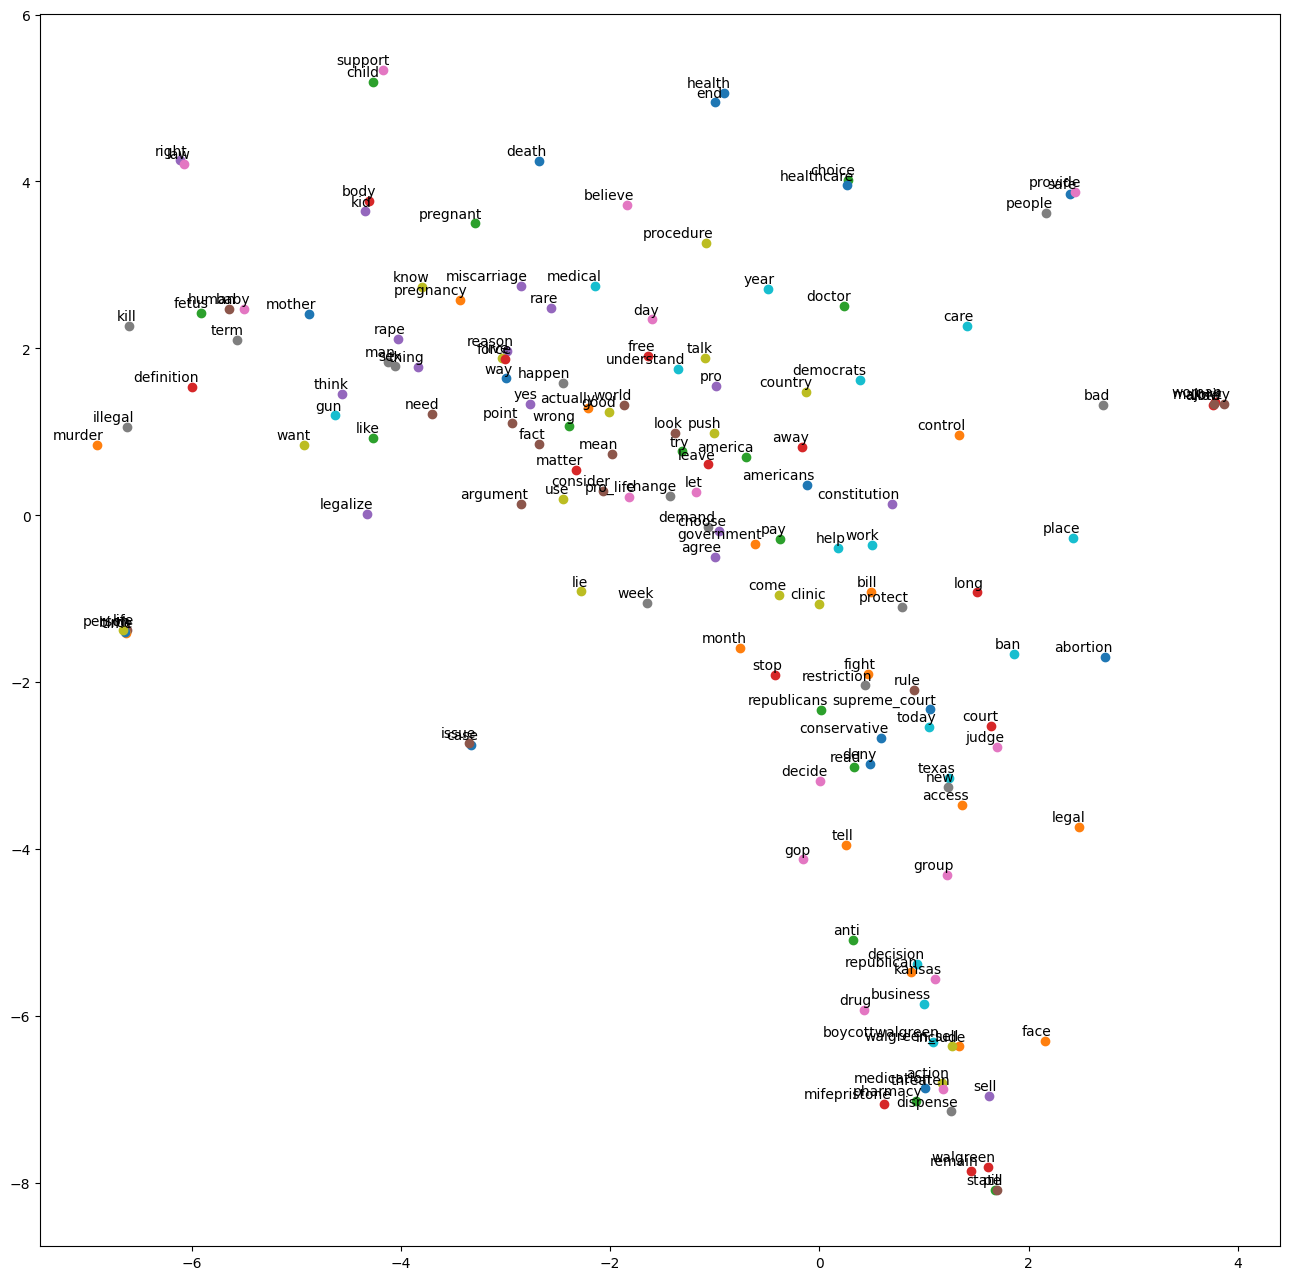

In [319]:
tsne_plot(w2v_model)

In [320]:
w2v_model.wv.most_similar(positive=["life"], negative=['killing'])

[('jesus_vow', 0.6508080363273621),
 ('law_prophets', 0.6380362510681152),
 ('wrong_god', 0.635729193687439),
 ('change_iota', 0.634328305721283),
 ('evangelical_catholics', 0.6337131857872009),
 ('require_circumst', 0.6173009276390076),
 ('murder_bible', 0.601769208908081),
 ('word', 0.20640353858470917),
 ('person', 0.1938331127166748),
 ('birth', 0.1385543942451477)]

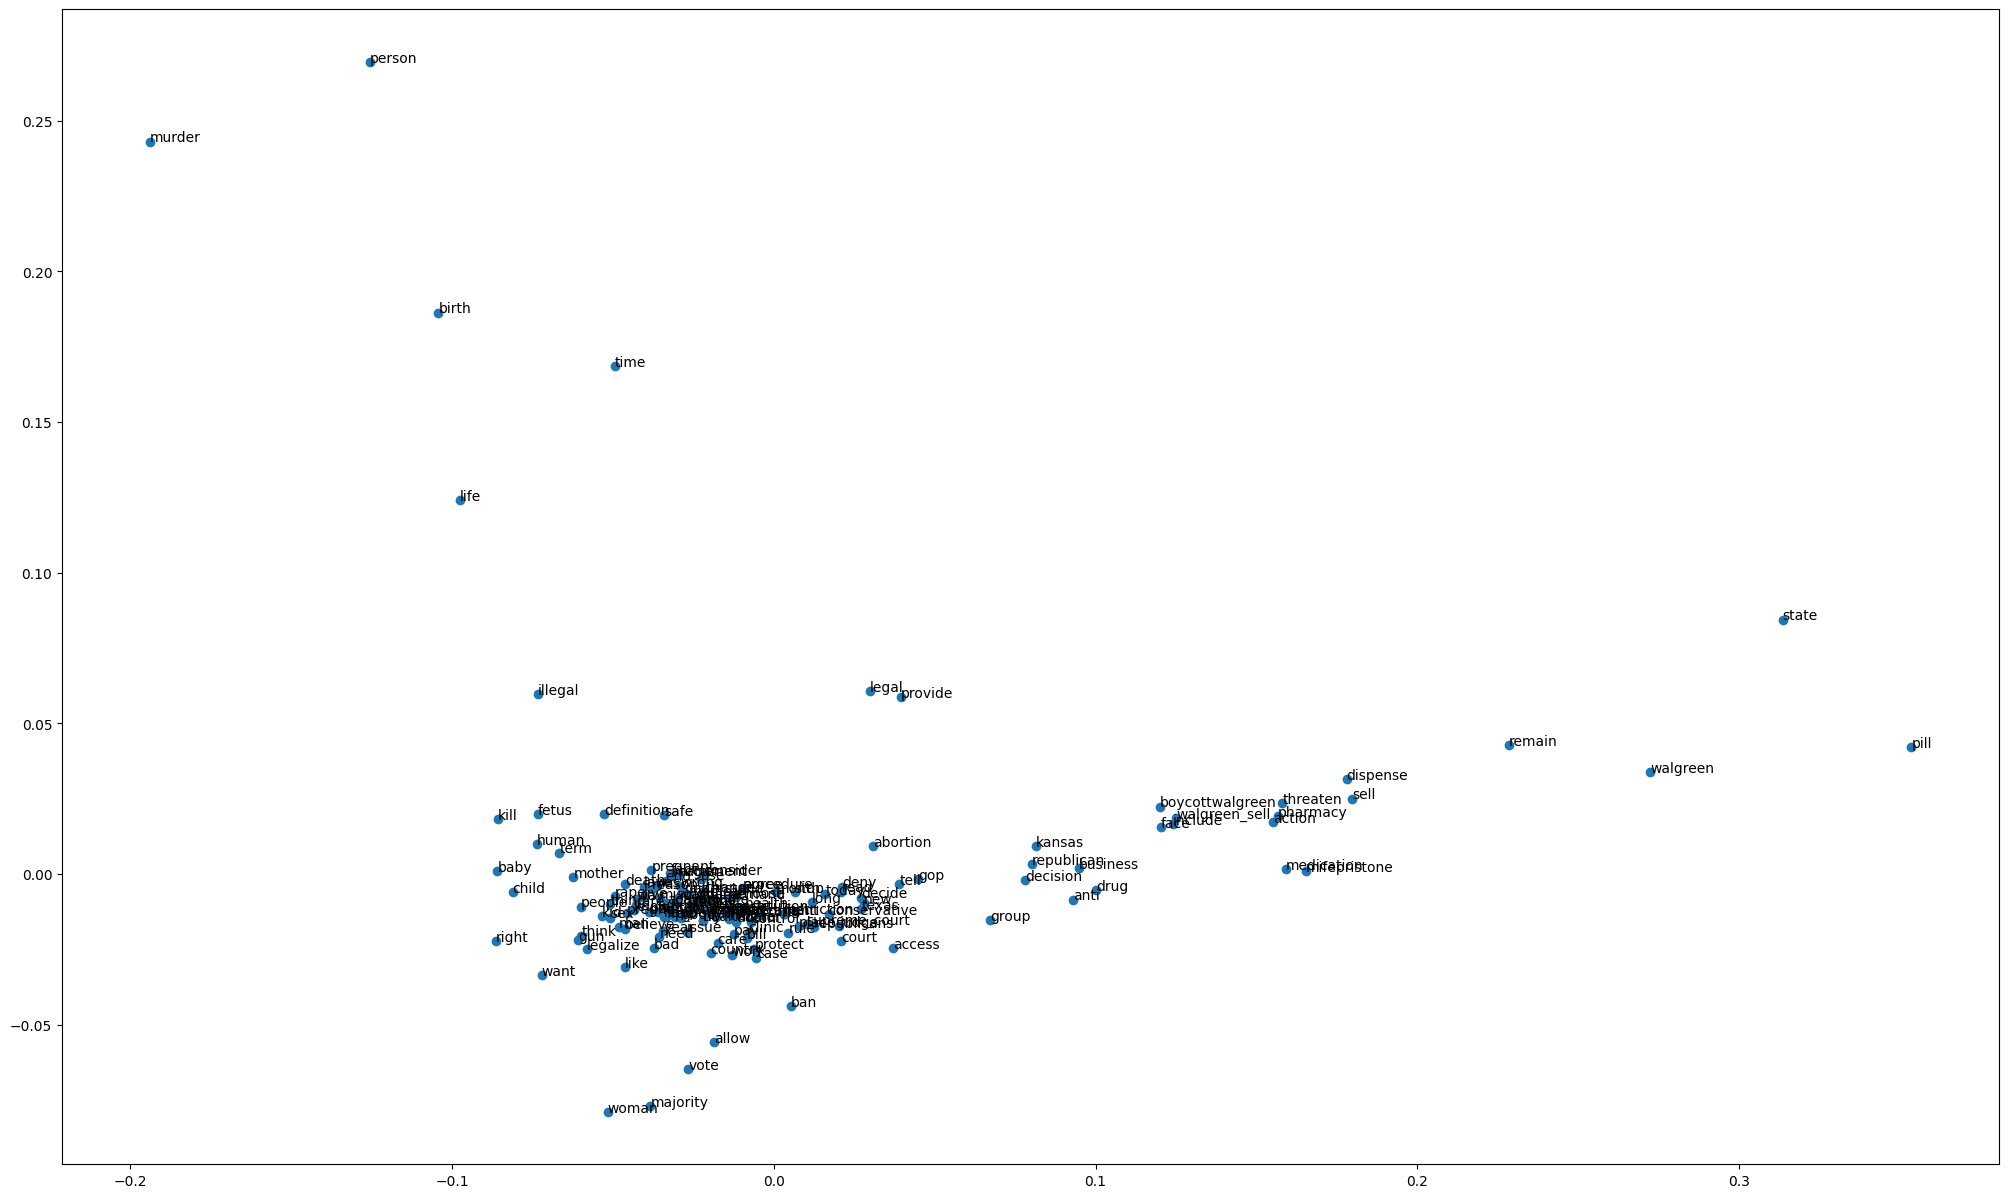

In [321]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Get the vocabulary and corresponding vectors from the Word2Vec model
vocab = list(w2v_model.wv.index_to_key)[:150]
vectors = w2v_model.wv.vectors[:150]

# Apply PCA to reduce the dimensionality of the vectors to 2
pca = PCA(n_components=2)
pca_vectors = pca.fit_transform(vectors)

# Plot the 2D representation of the vocabulary using Pyplot
fig, ax = plt.subplots(figsize=(25, 15))
ax.scatter(pca_vectors[:, 0], pca_vectors[:, 1])

# Add annotations for each word
for i, word in enumerate(vocab):
    ax.annotate(word, xy=(pca_vectors[i, 0], pca_vectors[i, 1]))
    
# Display the plot
plt.show()

# K Means clusters for sentiment

In [327]:
from sklearn.cluster import KMeans
word_vectors = Word2Vec.load("word2vec.model").wv

model = KMeans(n_clusters=2,
               max_iter=1000,
               random_state=True,
               n_init=50)
model.fit(X=word_vectors.vectors.astype('double'))

KMeans(max_iter=1000, n_clusters=2, n_init=50, random_state=True)

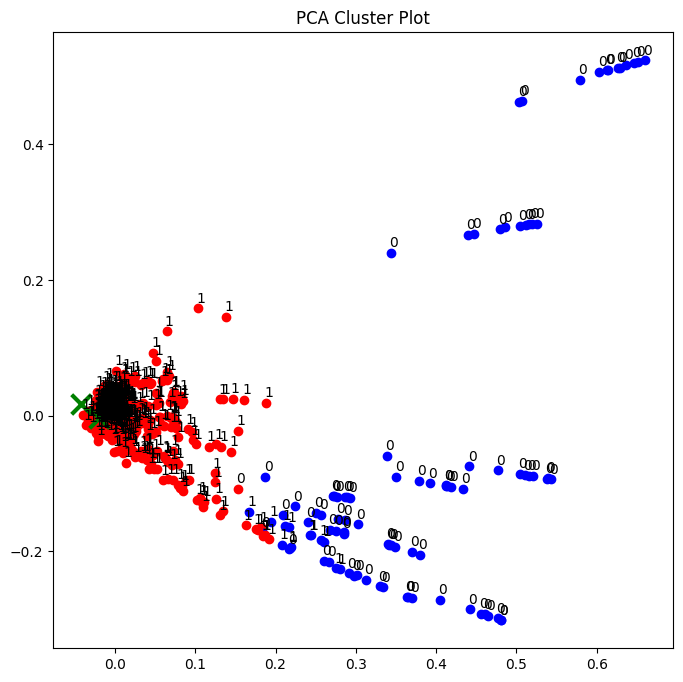

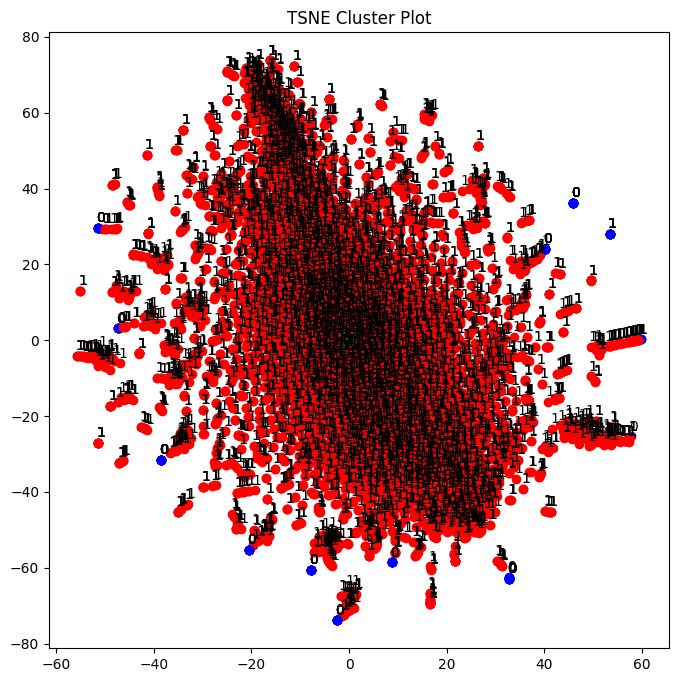

In [328]:
# Get the cluster labels and word vectors
cluster_labels = model.labels_
word_vecs = word_vectors.vectors

# Perform PCA on the word vectors
pca = PCA(n_components=2)
pca_vecs = pca.fit_transform(word_vecs)

# Perform TSNE on the word vectors
tsne = TSNE(n_components=2, random_state=0)
tsne_vecs = tsne.fit_transform(word_vecs)

# Create a PCA cluster plot
fig, ax = plt.subplots(figsize=(8, 8))
colors = ['r', 'b']
for i in range(len(word_vecs)):
    ax.scatter(pca_vecs[i, 0], pca_vecs[i, 1], color=colors[cluster_labels[i]])
    ax.annotate(labels[i],
                xy=(pca_vecs[i, 0], pca_vecs[i, 1]),
                xytext=(5, 2),
                textcoords='offset points',
                ha='right',
                va='bottom')
ax.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], marker='x', s=200, linewidths=3, color='g')
plt.title('PCA Cluster Plot')
plt.show()

# Create a TSNE cluster plot
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(len(word_vecs)):
    ax.scatter(tsne_vecs[i, 0], tsne_vecs[i, 1], color=colors[cluster_labels[i]])
    ax.annotate(labels[i],
                xy=(tsne_vecs[i, 0], tsne_vecs[i, 1]),
                xytext=(5, 2),
                textcoords='offset points',
                ha='right',
                va='bottom')
ax.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], marker='x', s=200, linewidths=3, color='g')
plt.title('TSNE Cluster Plot')
plt.show()


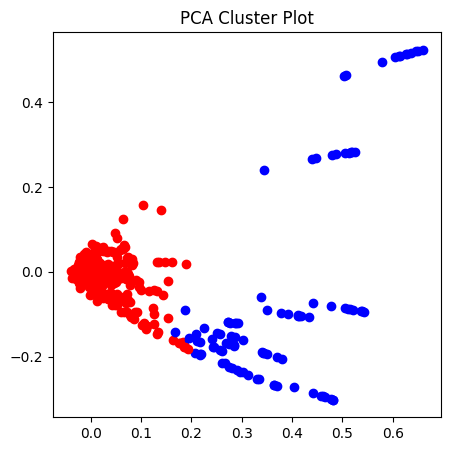

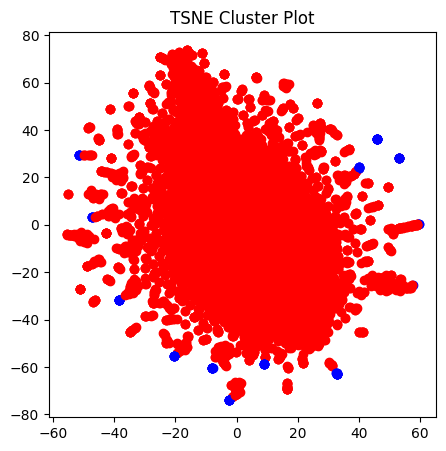

In [324]:
cluster_labels = model.labels_
word_vecs = word_vectors.vectors

# Perform PCA on the word vectors
pca = PCA(n_components=2)
pca_vecs = pca.fit_transform(word_vecs)

# Perform TSNE on the word vectors
tsne = TSNE(n_components=2, random_state=0)
tsne_vecs = tsne.fit_transform(word_vecs)

# Create a PCA cluster plot
plt.figure(figsize=(5, 5))
colors = ['r', 'b']
for i in range(len(word_vecs)):
    plt.scatter(pca_vecs[i, 0], pca_vecs[i, 1], color=colors[cluster_labels[i]])
plt.title('PCA Cluster Plot')
plt.show()

# Create a TSNE cluster plot
plt.figure(figsize=(5, 5))
for i in range(len(word_vecs)):
    plt.scatter(tsne_vecs[i, 0], tsne_vecs[i, 1], color=colors[cluster_labels[i]])
plt.title('TSNE Cluster Plot')
plt.show()

In [331]:
word_vectors.similar_by_vector(model.cluster_centers_[0], topn=50, restrict_vocab=None)

[('mexican', 0.9998114109039307),
 ('backfire', 0.9998058676719666),
 ('precaution', 0.9998056888580322),
 ('realistic', 0.9998046159744263),
 ('tellonym', 0.9998002052307129),
 ('wife_daughter', 0.9997990727424622),
 ('niece', 0.9997990727424622),
 ('tbh', 0.9997988939285278),
 ('1974', 0.9997974634170532),
 ('thankful', 0.9997955560684204),
 ('edge', 0.9997944831848145),
 ('starter', 0.9997926950454712),
 ('terrifying', 0.9997926354408264),
 ('destigmatize', 0.999792218208313),
 ('integrity', 0.9997913837432861),
 ('hmmm', 0.999790608882904),
 ('film', 0.999789834022522),
 ('defendant', 0.9997893571853638),
 ('throat', 0.9997890591621399),
 ('pov', 0.9997876882553101),
 ('perfect_example', 0.9997875094413757),
 ('angryface', 0.9997866153717041),
 ('calm', 0.9997862577438354),
 ('bent', 0.9997854232788086),
 ('hysterectomy', 0.9997851252555847),
 ('fact_straight', 0.9997844696044922),
 ('prime_example', 0.9997842907905579),
 ('adc', 0.9997836351394653),
 ('genius', 0.999782919883728),

In [332]:
positive_cluster_index = 0
positive_cluster_center = model.cluster_centers_[positive_cluster_index]
negative_cluster_center = model.cluster_centers_[1-positive_cluster_index]

In [333]:
words = pd.DataFrame(word_vectors.index_to_key)
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])
words['cluster_value'] = [1 if i==positive_cluster_index else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)
words['sentiment_coeff'] = words.closeness_score * words.cluster_value

In [334]:
filtered_words = words[words['cluster'] == 1]
filtered_words

words   
794   rollingonthefloorlaughe_rollingonthefloorlaughe  \
881                                    include_kansas   
970                                     care_customer   
972                                    pharmacy_voter   
1019                                      pass_ballot   
...                                               ...   
4935                                         wef_plan   
4953                             euthanasia_humiliate   
4970                                    medium_border   
4973                                  lose_technology   
4979                                 bankrupt_devalue   

                                                vectors  cluster   
794   [0.011417118, 0.045239367, 0.031643618, -0.080...        1  \
881   [-0.064979844, -0.009337296, 0.017079407, 0.04...        1   
970   [-0.06487822, -0.007936186, 0.016604558, 0.049...        1   
972   [-0.0669268, -0.00930405, 0.01705897, 0.048298...        1   
1019  [-0.065199345, -0.008158408, 0.018813077, 0.04...        1   
...                                                 ...      ...   
4935  [-0.008407903, -0.038440246, 0.015887182, 0.01...        1   
4953  [0.0055419644, -0.058334094, 0.023191381, 0.00...        1   
4970  [-0.003600241, -0.046246678, 0.015469048, 0.01...        1   
4973  [0.0007546518, -0.051084176, 0.020391127, 0.01...        1   
4979  [0.00039819392, -0.050493784, 0.019279636, 0.0...        1   

      cluster_value  closeness_score  sentiment_coeff  
794              -1         1.083827        -1.083827  
881              -1         1.423293        -1.423293  
970              -1         1.429726        -1.429726  
972              -1         1.414951        -1.414951  
1019             -1         1.364671        -1.364671  
...             ...              ...              ...  
4935             -1         1.961155        -1.961155  
4953             -1         1.555114        -1.555114  
4970             -1         1.801756        -1.801756  
4973             -1         1.703880        -1.703880  
4979             -1         1.672879        -1.672879  

[99 rows x 6 columns]

In [335]:
words[['words', 'sentiment_coeff']].to_csv('sentiment_dictionary.csv', index=False)

In [336]:
words.groupby(['cluster']).count()

words  vectors  cluster_value  closeness_score  sentiment_coeff
cluster                                                                 
0         5728     5728           5728             5728             5728
1           99       99             99               99               99

In [337]:
words

words                                            vectors  cluster   
0       abortion  [-0.043260653, 0.022011716, -0.0048065395, 0.0...        0  \
1          legal  [-0.04157266, 0.023069734, -0.014665375, 0.019...        0   
2          state  [-0.03110823, 0.01617561, -0.023504809, 0.0349...        0   
3          woman  [-0.054730188, 0.015126516, -0.013593568, 0.03...        0   
4          right  [-0.05821899, 0.03345647, -0.021451442, 0.0057...        0   
...          ...                                                ...      ...   
5822   selection  [-0.041350763, 0.018619495, -0.014008942, 0.01...        0   
5823       gutte  [-0.043730956, 0.016555743, -0.0136914635, 0.0...        0   
5824   egregious  [-0.04313343, 0.017305737, -0.014204352, 0.021...        0   
5825      annual  [-0.04309764, 0.017278036, -0.015436174, 0.019...        0   
5826  workaround  [-0.04137542, 0.016703483, -0.0138383815, 0.01...        0   

      cluster_value  closeness_score  sentiment_coeff  
0                 1         8.783807         8.783807  
1                 1         9.201895         9.201895  
2                 1         2.900884         2.900884  
3                 1         5.823708         5.823708  
4                 1         5.847028         5.847028  
...             ...              ...              ...  
5822              1        44.539144        44.539144  
5823              1        42.315812        42.315812  
5824              1        41.508004        41.508004  
5825              1        39.934927        39.934927  
5826              1        45.729773        45.729773  

[5827 rows x 6 columns]

# Labelling data

In [338]:
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [339]:
final_file = pd.read_csv('cleaned_dataset.csv')
sentiment_map = pd.read_csv('sentiment_dictionary.csv')
sentiment_dict = dict(zip(sentiment_map.words.values, sentiment_map.sentiment_coeff.values))

In [340]:
# Select rows where 'lemmas_with_bigrams' is NaN
file_weighting = final_file.copy()
nan_rows = final_file.loc[final_file.lemmas_with_bigrams.isna()]

# Print the selected rows
print(nan_rows)


      lemmas_with_bigrams
2913                  NaN
3954                  NaN
5443                  NaN
7857                  NaN
10160                 NaN
10696                 NaN
13220                 NaN
14339                 NaN
14478                 NaN
15878                 NaN
18882                 NaN
21057                 NaN


In [341]:
file_weighting.lemmas_with_bigrams

0        ron_desantis state honor legal requirement ext...
1                   abortion completely legal constitution
2        force pregnancy legal term specifically relate...
3               americans know true believe abortion legal
4                 democrats want legalize abortion scruple
                               ...                        
22482    abortion month legal past trimester illegal im...
22483    scotus_rule decade_ago privacy fundamental_rig...
22484                       yes mean obtain abortion legal
22485    injunction incorrectly place trigger ban abort...
22486    blue america want abortion legal mother baby h...
Name: lemmas_with_bigrams, Length: 22487, dtype: object

In [342]:
# Drop rows with NaN values in the 'lemmas_with_bigrams' column
file_weighting = final_file.copy()
file_weighting = file_weighting.dropna(subset=['lemmas_with_bigrams'])
file_weighting = file_weighting.reset_index(drop=True)

tfidf = TfidfVectorizer(tokenizer=lambda y: y.split(), norm=None, min_df=0, stop_words=None)
tfidf.fit(file_weighting.lemmas_with_bigrams)
features = pd.Series(tfidf.get_feature_names_out())
transformed = tfidf.transform(file_weighting.lemmas_with_bigrams)
features = features.str.strip()

/Users/lst/myenv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [343]:
features

0             000
1            0001
2            000s
3           00138
4            0025
           ...   
17878        zone
17879         zoo
17880      zoomer
17881    zurawski
17882      zygote
Length: 17883, dtype: object

In [344]:
file_weighting.lemmas_with_bigrams.info()


<class 'pandas.core.series.Series'>
RangeIndex: 22475 entries, 0 to 22474
Series name: lemmas_with_bigrams
Non-Null Count  Dtype 
--------------  ----- 
22475 non-null  object
dtypes: object(1)
memory usage: 175.7+ KB


In [345]:
features.info()

<class 'pandas.core.series.Series'>
RangeIndex: 17883 entries, 0 to 17882
Series name: None
Non-Null Count  Dtype 
--------------  ----- 
17883 non-null  object
dtypes: object(1)
memory usage: 139.8+ KB


In [346]:
def create_tfidf_dictionary(x, transformed_file, features):
    '''
    create dictionary for each input sentence x, where each word has assigned its tfidf score
    
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer

    '''
    vector_coo = transformed_file[x.name].tocoo()
    vector_coo.col = features.iloc[vector_coo.col].values
    dict_from_coo = dict(zip(vector_coo.col, vector_coo.data))
    return dict_from_coo

def replace_tfidf_words(x, transformed_file, features):
    '''
    replacing each word with it's calculated tfidf dictionary with scores of each word
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer
    '''
    dictionary = create_tfidf_dictionary(x, transformed_file, features)   
    words = [word.lower() for word in x.lemmas_with_bigrams.split()]
    tfidf_scores = [dictionary.get(word, 0) for word in words]
    return tfidf_scores

In [347]:
# %%time
replaced_tfidf_scores = file_weighting.apply(lambda x: replace_tfidf_words(x, transformed, features), axis=1)

In [348]:
def replace_sentiment_words(word, sentiment_dict):
    '''
    replacing each word with its associated sentiment score from sentiment dict
    '''
    try:
        out = sentiment_dict[word]
    except KeyError:
        out = 0
    return out

In [349]:
replaced_closeness_scores = file_weighting.lemmas_with_bigrams.apply(lambda x: list(map(lambda y: replace_sentiment_words(y, sentiment_dict), x.split())))

In [350]:
replacement_df = pd.DataFrame(data=[replaced_closeness_scores, replaced_tfidf_scores, file_weighting.lemmas_with_bigrams]).T
replacement_df.columns = ['sentiment_coeff', 'tfidf_scores', 'sentence']
replacement_df['sentiment_rate'] = replacement_df.apply(lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']), axis=1)
replacement_df['prediction'] = (replacement_df.sentiment_rate>0).astype('int8')

In [351]:
replacement_df

sentiment_coeff   
0      [28.617646198798663, 2.9008839893094507, 42.35...  \
1      [8.783806744985379, 35.34719254537998, 9.20189...   
2      [17.419168945106698, 15.435897121183888, 9.201...   
3      [23.177356381257663, 14.991453518522857, 26.56...   
4      [15.345779468738998, 9.259916677068816, 10.493...   
...                                                  ...   
22470  [8.783806744985379, 25.382922968424992, 9.2018...   
22471  [33.55993124526565, 14.002206936731074, 32.744...   
22472  [20.215091076656822, 21.844377899879905, 21.60...   
22473  [22.586409240556147, 30.073238678895056, 14.95...   
22474  [25.713860056958666, 22.1098164969539, 9.25991...   

                                            tfidf_scores   
0      [8.53529670244409, 4.710905192916473, 7.762106...  \
1      [1.0464903548064637, 6.071443461853921, 1.0919...   
2      [4.982332432309951, 4.732344792070304, 1.09192...   
3      [5.407075245844019, 4.045724441207044, 5.84405...   
4      [5.277200164422607, 3.4929474328583052, 4.2278...   
...                                                  ...   
22470  [1.0464903548064637, 5.399802486514939, 1.0919...   
22471  [8.940761810552253, 7.762106814210607, 7.28253...   
22472  [5.087958164784078, 4.669317635517349, 5.98325...   
22473  [7.687998842056885, 8.82297877489587, 5.104001...   
22474  [7.306631285527781, 5.364211541412236, 3.49294...   

                                                sentence  sentiment_rate   
0      ron_desantis state honor legal requirement ext...     3664.935953  \
1                 abortion completely legal constitution      348.475898   
2      force pregnancy legal term specifically relate...     3376.181075   
3             americans know true believe abortion legal      422.037314   
4               democrats want legalize abortion scruple      166.882916   
...                                                  ...             ...   
22470  abortion month legal past trimester illegal im...     1765.452703   
22471  scotus_rule decade_ago privacy fundamental_rig...     2126.224229   
22472                     yes mean obtain abortion legal      353.338117   
22473  injunction incorrectly place trigger ban abort...     1979.354700   
22474  blue america want abortion legal mother baby h...     1023.074001   

       prediction  
0               1  
1               1  
2               1  
3               1  
4               1  
...           ...  
22470           1  
22471           1  
22472           1  
22473           1  
22474           1  

[22475 rows x 5 columns]

In [352]:
replacement_df[replacement_df['prediction'] == 0]

sentiment_coeff   
1674   [2.6478577011669486, 9.201895307749862, -1.675...  \
3151   [2.6478577011669486, 9.201895307749862, -1.675...   
3152   [2.6478577011669486, 9.201895307749862, -1.675...   
5999                                                 [0]   
7945                                              [0, 0]   
10679  [9.201895307749862, 8.783806744985379, 12.6632...   
10984  [2.6478577011669486, 9.201895307749862, -1.675...   
11007  [2.6478577011669486, 9.201895307749862, -1.675...   
11011  [2.6478577011669486, 9.201895307749862, -1.675...   
11874  [2.6478577011669486, 9.201895307749862, -1.675...   
15554  [0, 4.203665807274667, -1.561018450605259, -1....   
15561  [0, -1.561018450605259, -1.399065159979092, -1...   
15607  [2.6478577011669486, 9.201895307749862, -1.675...   
15719  [0, -1.561018450605259, -1.399065159979092, -1...   
15743  [0, -1.561018450605259, -1.399065159979092, -1...   
15744  [0, -1.561018450605259, -1.399065159979092, -1...   
15829  [-1.4149512575755785, -1.423292737673992, -1.3...   
15840  [7.433665616779545, 0, -1.561018450605259, -1....   
15862  [-1.561018450605259, -1.399065159979092, -1.38...   
15901  [-1.561018450605259, -1.399065159979092, -1.38...   
15902  [0, 0, -1.561018450605259, -1.399065159979092,...   
16575                                             [0, 0]   
18123  [2.6478577011669486, 9.201895307749862, -1.675...   
20694                                                [0]   
21916  [2.6478577011669486, 9.201895307749862, -1.675...   

                                            tfidf_scores   
1674   [7.892173072069453, 1.091925630888742, 7.68799...  \
3151   [7.892173072069453, 1.091925630888742, 7.68799...   
3152   [7.892173072069453, 1.091925630888742, 7.68799...   
5999                                 [9.410765439797988]   
7945              [9.633908991112198, 9.410765439797988]   
10679  [1.091925630888742, 1.0464903548064637, 6.7297...   
10984  [7.892173072069453, 1.091925630888742, 7.68799...   
11007  [7.892173072069453, 1.091925630888742, 7.68799...   
11011  [7.892173072069453, 1.091925630888742, 7.68799...   
11874  [7.892173072069453, 1.091925630888742, 7.68799...   
15554  [9.633908991112198, 9.228443883004033, 8.71761...   
15561  [10.327056171672144, 8.717618259238044, 8.7176...   
15607  [7.892173072069453, 1.091925630888742, 7.68799...   
15719  [9.410765439797988, 8.717618259238044, 8.71761...   
15743  [9.921591063563978, 8.717618259238044, 8.71761...   
15744  [9.921591063563978, 8.717618259238044, 8.71761...   
15829  [7.17005575052203, 7.068959633650661, 7.213540...   
15840  [8.622308079433719, 10.327056171672144, 8.7176...   
15862  [8.717618259238044, 8.717618259238044, 8.71761...   
15901  [8.717618259238044, 8.717618259238044, 8.71761...   
15902  [9.633908991112198, 9.410765439797988, 8.71761...   
16575           [10.327056171672144, 10.327056171672144]   
18123  [7.892173072069453, 1.091925630888742, 7.68799...   
20694                                [9.921591063563978]   
21916  [7.892173072069453, 1.091925630888742, 7.68799...   

                                                sentence  sentiment_rate   
1674   murder legal terminology abortion illegal murd...      -30.584432  \
3151   murder legal terminology abortion illegal murd...      -18.166811   
3152   murder legal terminology abortion illegal murd...      -19.439561   
5999                                        article_link        0.000000   
7945                                      impeach fucker        0.000000   
10679  legal abortion low risk death rollingonthefloo...    -4076.811628   
10984  murder legal terminology abortion illegal murd...      -18.166811   
11007  murder legal terminology abortion illegal murd...      -30.584432   
11011  murder legal terminology abortion illegal murd...      -18.166811   
11874  murder legal terminology abortion illegal murd...      -30.584432   
15554  rick wilson white_democrat start_civil war_bla...      -88.068393   
15561  

In [353]:
replacement_df.groupby(['prediction']).count()

sentiment_coeff  tfidf_scores  sentence  sentiment_rate
prediction                                                         
0                        25            25        25              25
1                     22450         22450     22450           22450

In [354]:
replacement_df.to_csv('labeled_tweets.csv')

 # I prepared my own-labeled tweets to compare results. I labaled by hand 150 first tweets.

In [355]:
hands_labeled_tweets = pd.read_excel('hands_labeled_tweets.xlsx')

In [356]:
hands_labeled_tweets

sentiment_coeff   
0    [24.803990036749585, 2.625223830334656, 42.164...  \
1    [8.715086358693046, 36.61220803415641, 9.37995...   
2    [18.989024687932663, 14.37917978269016, 9.3799...   
3    [24.53331710394931, 13.87584610591396, 37.8533...   
4    [14.917759570970384, 9.15168561027776, 9.32147...   
..                                                 ...   
146  [8.715086358693046, 17.627744851895073, 9.3799...   
147  [26.07357456221092, 12.770028445622668, 20.791...   
148  [28.811111243959477, 3.590144296692006, 8.7150...   
149  [16.95440133213699, 34.90624089282973, 8.71508...   
150  [8.715086358693046, 2.3938098018615594, 8.7150...   

                                          tfidf_scores   
0    [8.53529670244409, 4.710905192916473, 7.762106...  \
1    [1.0464903548064637, 6.071443461853921, 1.0919...   
2    [4.982332432309951, 4.732344792070304, 1.09192...   
3    [5.407075245844019, 4.045724441207044, 5.84405...   
4    [5.277200164422607, 3.4929474328583052, 4.2278...   
..                                                 ...   
146  [1.0464903548064637, 4.479173353042185, 1.0919...   
147  [5.677869100267277, 5.194203244851638, 5.04894...   
148  [6.925858790009988, 4.014414332978586, 3.13947...   
149  [5.033751346947651, 6.435235873561517, 1.04649...   
150  [2.0929807096129274, 19.73043268017363, 2.0929...   

                                              sentence  sentiment_rate   
0    ron_desantis state honor legal requirement ext...     3520.174098  \
1               abortion completely legal constitution      366.989242   
2    force pregnancy legal term specifically relate...     3374.294656   
3           americans know true believe abortion legal      490.607327   
4             democrats want legalize abortion scruple      159.220511   
..                                                 ...             ...   
146  abortion week legal murder hundredpoint hundre...     1286.082231   
147  hear human use abortion birth_control brutal a...     1645.690014   
148  team support abortion expect matter urgency re...     2530.747666   
149                            new fall abortion legal      329.336606   
150  abortion murder abortion legal murder murder s...     2055.980712   

     prediction  hand_labels  
0             1            1  
1             1            0  
2             1            1  
3             1            0  
4             1            1  
..          ...          ...  
146           1            1  
147           1            1  
148           1            0  
149           1            0  
150           1            1  

[151 rows x 6 columns]

In [357]:
predicted_classes = hands_labeled_tweets.prediction
y_test = hands_labeled_tweets.hand_labels

conf_matrix = pd.DataFrame(confusion_matrix(hands_labeled_tweets.hand_labels, hands_labeled_tweets.prediction))
print('Confusion Matrix')
display(conf_matrix)

test_scores = accuracy_score(y_test,predicted_classes), precision_score(y_test, predicted_classes), recall_score(y_test, predicted_classes), f1_score(y_test, predicted_classes)

print('\n \n Scores')
scores = pd.DataFrame(data=[test_scores])
scores.columns = ['accuracy', 'precision', 'recall', 'f1']
scores = scores.T
scores.columns = ['scores']
display(scores)

Confusion Matrix


0   1
0  0  99
1  0  52


 
 Scores


scores
accuracy   0.344371
precision  0.344371
recall     1.000000
f1         0.512315

 # Accuracy score is low, only 34%. I will try different approach in another notebook - ZeroShot labelling